In [1]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry

In [2]:
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [3]:
from astropy import stats
from astropy.table import Table
from astropy.wcs import WCS

In [4]:
from astropy.io import fits

In [5]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'

In [6]:
from astroquery.svo_fps import SvoFps

In [7]:
import numpy as np

In [8]:
import reproject

In [9]:
from astropy import units as u

In [10]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [11]:
fh_405 = fits.open(f'{basepath}/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-merged-reproject_i2d.fits')
fh_410 = fits.open(f'{basepath}/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-merged-reproject_i2d.fits')

In [12]:
ww405 = wcs.WCS(fh_405['SCI'].header)
ww410 = wcs.WCS(fh_410['SCI'].header)

In [13]:
instrument = fh_405[0].header['INSTRUME']
telescope = fh_405[0].header['TELESCOP']
filt405 = fh_405[0].header['PUPIL']
wavelength_table_405 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt405}')
filt410 = fh_410[0].header['FILTER']
wavelength_table_410 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt410}')

In [14]:
filt405, filt410

('F405N', 'F410M')

In [15]:
waves_410 = wavelength_table_410['Wavelength']
trans_405 = np.interp(waves_410, wavelength_table_405['Wavelength'], wavelength_table_405['Transmission'])
trans_410 = wavelength_table_410['Transmission']

Text(0.5, 0, 'Wavelength [Angstroms]')

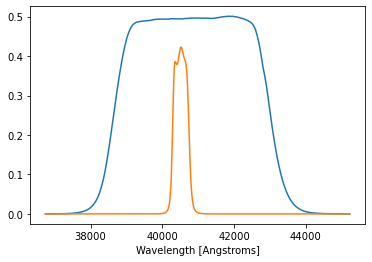

In [16]:
pl.plot(waves_410, trans_410)
pl.plot(waves_410, trans_405)
pl.xlabel("Wavelength [Angstroms]")

In [17]:
fractional_bandwidth_405 = (( (trans_410/trans_410.max()) *
                            (trans_405/trans_405.max()) ).sum()
                            / (trans_410/trans_410.max()).sum()
                           )
fractional_bandwidth_405

0.1027882360899125

In [18]:
fraction_bandwidth_empirical = 0.1742 # see end of document

In [19]:
data_405_proj_410 = reproject.reproject_exact(fh_405['SCI'], fh_410['SCI'].header)

In [20]:
from astropy.convolution import convolve_fft, Gaussian2DKernel

### from PSF analysis below, we need to smooth the BrA data with an 0.3 pix gaussian

In [21]:
cont410_sub_bra = fh_410['SCI'].data - convolve_fft(data_405_proj_410[0]*fractional_bandwidth_405, Gaussian2DKernel(0.3))
fits.PrimaryHDU(data=cont410_sub_bra, header=fh_410['SCI'].header).writeto(f'{basepath}/images/F410_minus_F405_merged-reproject_theoretical_bandwidth.fits', overwrite=True)

In [22]:
bra_minus_cont = data_405_proj_410[0] - cont410_sub_bra #* fractional_bandwidth_405
fits.PrimaryHDU(data=bra_minus_cont, header=fh_410['SCI'].header).writeto(f'{basepath}/images/F405_minus_F410cont_merged-reproject_theoretical_bandwidth.fits', overwrite=True)

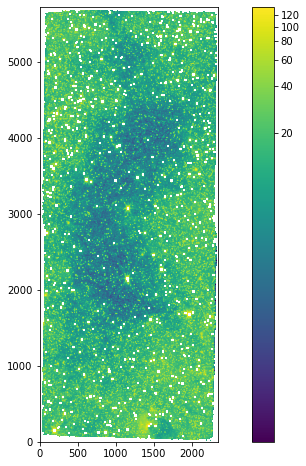

In [23]:
pl.figure(figsize=(12,8))
pl.imshow(fh_410['SCI'].data, norm=simple_norm(cont410_sub_bra, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar()

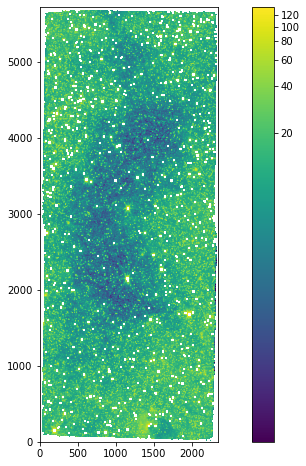

In [24]:
pl.figure(figsize=(12,8))
pl.imshow(cont410_sub_bra, norm=simple_norm(cont410_sub_bra, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar()

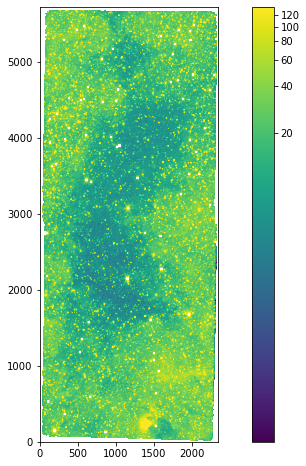

In [25]:
pl.figure(figsize=(12,8))
pl.imshow(fh_405['SCI'].data, norm=simple_norm(cont410_sub_bra, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar()

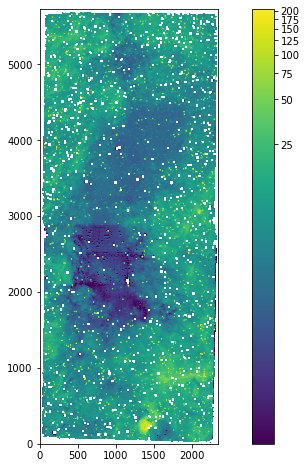

In [26]:
pl.figure(figsize=(12,8))
pl.imshow(bra_minus_cont, norm=simple_norm(bra_minus_cont, min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

# PSF comparison

There was evidence of oversubtraction / undersubtraction in rings around the stars in the 405-410 image before we did PSF convolution:

In [27]:
class slcgt:
    def __getitem__(self, args):
        return args

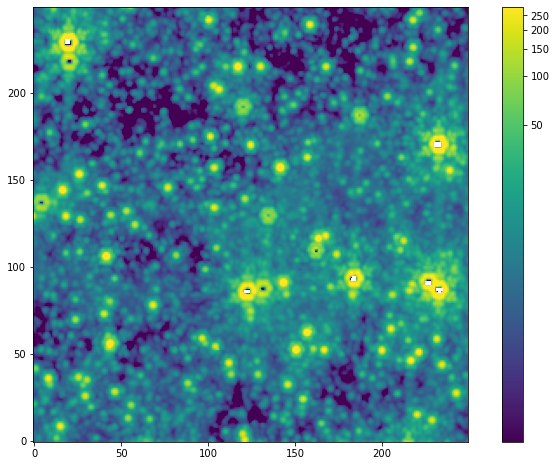

In [28]:
dd = fh_410['SCI'].data
pl.figure(figsize=(12,8))
slc = slcgt()[1000:1250,1000:1250]
pl.imshow(dd[slc],
          norm=simple_norm(dd[slc], min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

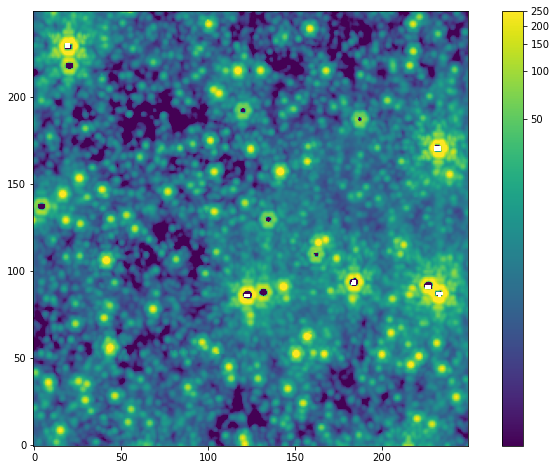

In [29]:
pl.figure(figsize=(12,8))
slc = slcgt()[1000:1250,1000:1250]
pl.imshow(cont410_sub_bra[slc],
          norm=simple_norm(cont410_sub_bra[slc], min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

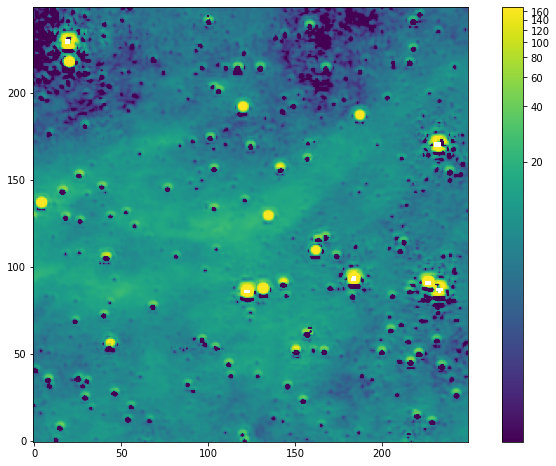

In [30]:
pl.figure(figsize=(12,8))
slc = slcgt()[1000:1250,1000:1250]
pl.imshow(bra_minus_cont[slc],
          norm=simple_norm(bra_minus_cont[slc], min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

and now..... it looks the same!!!  YAY.  !@#$!@#$

In [31]:
import os
os.environ['WEBBPSF_PATH'] = '/orange/adamginsburg/jwst/webbpsf-data/'
import webbpsf
from webbpsf.utils import to_griddedpsfmodel

In [32]:
import sys
sys.path.append(f'{basepath}/reduction/')

In [36]:
import saturated_star_finding
import imp
imp.reload(saturated_star_finding)
from saturated_star_finding import get_psf

In [37]:
psf_bra = get_psf(fh_405['SCI'].header)

INFO: MAST API token accepted, welcome Adam Ginsburg [astroquery.mast.auth]
Attempting to load PSF for 2022-08-28

MAST OPD query around UTC: 2022-08-28T00:00:00.000
                        MJD: 59819.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022082702-NRCA3_FP1-1.fits
	Date (MJD):	 59817.7488
	Delta time:	 -1.2512 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022082902-NRCA3_FP1-1.fits
	Date (MJD):	 59819.7687
	Delta time:	 0.7687 days
User requested choosing OPD time closest in time to 2022-08-28T00:00:00.000, which is R2022082902-NRCA3_FP1-1.fits, delta time 0.769 days
INFO: MAST API token accepted, welcome Adam Ginsburg [astroquery.mast.auth]
Importing and format-converting OPD from /orange/adamginsburg/jwst/webbpsf-data/MAST_JWST_WSS_OPDs/R2022082902-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
INFO: starfinding: Calculating grid for psf_fn=./nircam_F405N_samp2_nspsf16_

In [38]:
psf_410 = get_psf(fh_410['SCI'].header)

INFO: MAST API token accepted, welcome Adam Ginsburg [astroquery.mast.auth]
Attempting to load PSF for 2022-08-28

MAST OPD query around UTC: 2022-08-28T00:00:00.000
                        MJD: 59819.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022082702-NRCA3_FP1-1.fits
	Date (MJD):	 59817.7488
	Delta time:	 -1.2512 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022082902-NRCA3_FP1-1.fits
	Date (MJD):	 59819.7687
	Delta time:	 0.7687 days
User requested choosing OPD time closest in time to 2022-08-28T00:00:00.000, which is R2022082902-NRCA3_FP1-1.fits, delta time 0.769 days
Importing and format-converting OPD from /orange/adamginsburg/jwst/webbpsf-data/MAST_JWST_WSS_OPDs/R2022082902-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
INFO: starfinding: Calculating grid for psf_fn=./nircam_F410M_samp2_nspsf16_npix512.fits [saturated_star_finding]

Running instrument: NIRCam, filter: F

In [39]:
from astropy.visualization import imshow_norm, simple_norm, LogStretch, AsinhStretch

(<matplotlib.image.AxesImage at 0x2b9e89d64d30>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x2b9ea43bcd60>)

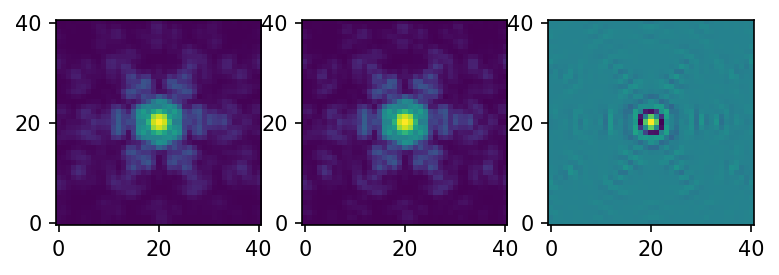

In [40]:
yy, xx = np.mgrid[-20:20.1:1,-20:20.1:1]
pl.figure(dpi=150)
ax = pl.subplot(1,3,1)
imshow_norm(psf_410(xx, yy), ax=ax, stretch=LogStretch())
ax = pl.subplot(1,3,2)
imshow_norm(psf_bra(xx, yy), ax=ax, stretch=LogStretch())
ax = pl.subplot(1,3,3)
imshow_norm(psf_bra(xx, yy) - psf_410(xx, yy), ax=ax, stretch=AsinhStretch())

In [41]:
pb = psf_bra(xx, yy)
p4 = psf_410(xx, yy)
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel, AiryDisk2DKernel
def residual(x):
    return convolve(pb, Gaussian2DKernel(x)) - p4
def aresidual(x):
    return convolve(pb, AiryDisk2DKernel(x)) - p4

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/convolution/kernels.py:162: RuntimeWarning: divide by zero encountered in double_scalars
  self._model = models.Gaussian2D(1. / (2 * np.pi * x_stddev * y_stddev),
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/modeling/functional_models.py:409: RuntimeWarning: divide by zero encountered in divide
  a = 0.5 * ((cost2 / xstd2) + (sint2 / ystd2))
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/modeling/functional_models.py:409: RuntimeWarning: invalid value encountered in divide
  a = 0.5 * ((cost2 / xstd2) + (sint2 / ystd2))
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/modeling/functional_models.py:410: RuntimeWarning: invalid value encountered in divide
  b = 0.5 * ((sin2t / xstd2) - (sin2t / ystd2))
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/modeling/functional_m

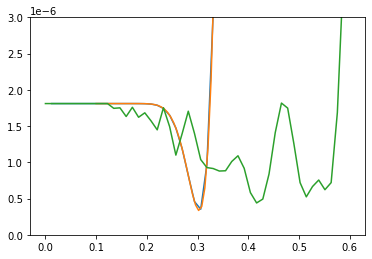

In [42]:
pl.plot(np.linspace(0,0.6), [(residual(x)**2).sum() for x in np.linspace(0,0.6)])
pl.plot(np.linspace(0.1,0.4), [(residual(x)**2).sum() for x in np.linspace(0.1,0.4)])
pl.plot(np.linspace(0,0.6), [(aresidual(x)**2).sum() for x in np.linspace(0,0.6)])
pl.ylim(0,0.000003);

In [43]:
resids = [(residual(x)**2).sum() for x in np.linspace(0.2,0.4)]
np.linspace(0.2,0.4)[np.argmin(resids)]

0.3020408163265306

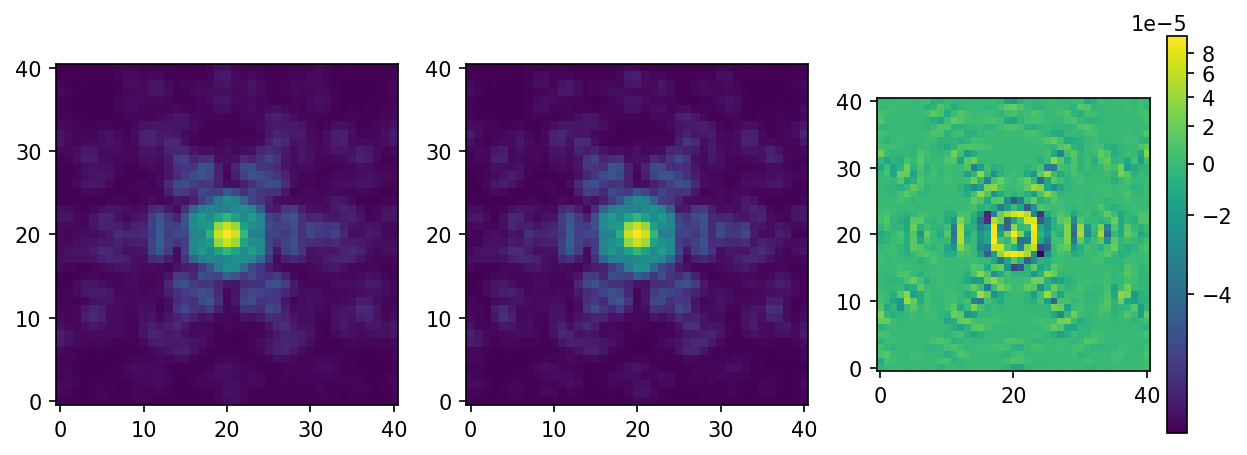

In [44]:
yy, xx = np.mgrid[-20:20.1:1,-20:20.1:1]
pl.figure(dpi=150, figsize=(10,3.5))
ax = pl.subplot(1,3,1)
imshow_norm(psf_410(xx, yy), ax=ax, stretch=LogStretch())
ax = pl.subplot(1,3,2)
imshow_norm(psf_bra(xx, yy), ax=ax, stretch=LogStretch())
ax = pl.subplot(1,3,3)
im, norm = imshow_norm(convolve(psf_bra(xx, yy), Gaussian2DKernel(0.3)) - psf_410(xx, yy), ax=ax, stretch=AsinhStretch())
pl.colorbar(mappable=im)

In [45]:
Gaussian2DKernel(0.3, x_size=xx.shape[1], y_size=yy.shape[0]).array.shape

(41, 41)

### Attempt direct deconvolution

Maybe a Gaussian isn't the right kernel?

In [46]:
ft4 = np.fft.fftshift(np.fft.fft2(psf_410(xx, yy)))
ftb = np.fft.fftshift(np.fft.fft2(psf_bra(xx, yy)))
ftk = np.fft.fftshift(np.fft.fft2(Gaussian2DKernel(0.3, x_size=xx.shape[1], y_size=yy.shape[0]).array))

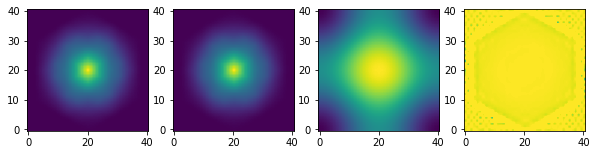

In [47]:
pl.figure(figsize=(10,3))
pl.subplot(1,4,1)
pl.imshow(np.abs(ftb))
pl.subplot(1,4,2)
pl.imshow(np.abs(ft4))
pl.subplot(1,4,3)
pl.imshow(np.abs(ftk))
pl.subplot(1,4,4)
pl.imshow(np.abs(ft4/ftb), vmin=0, vmax=1)

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


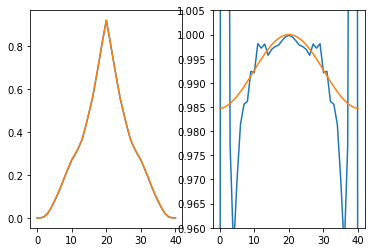

In [48]:
#im, norm = imshow_norm(np.abs(ft4)/np.abs(ftb) * np.abs(ftb) > 1e-3, stretch=AsinhStretch(), vmax=1.1, vmin=0.9)
#pl.colorbar(mappable=im)
pl.subplot(1,2,1)
pl.plot(np.abs((ft4[20,:])))
pl.plot(np.abs((ftb[20,:])))
pl.subplot(1,2,2)
pl.plot(np.abs((ft4[20,:])) / np.abs((ftb[20,:])))
pl.plot(np.abs(ftk[20,:]) / ftk.max())
pl.ylim(0.96, 1.005);

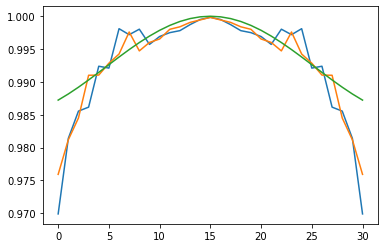

In [49]:
pl.plot((ft4[20,5:-5] / ftb[20,5:-5]))
pl.plot((ft4[5:-5,20] / ftb[5:-5,20]))
pl.plot(np.abs(ftk[5:-5,20])/np.abs(ftk).max())

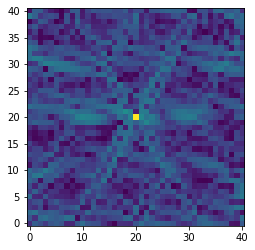

In [50]:
bra_to_410_kernel = np.abs((np.fft.fftshift(np.fft.fft2(ft4/ftb))))
bra_to_410_kernel /= bra_to_410_kernel.max()
imshow_norm(bra_to_410_kernel, stretch=LogStretch())
bra_to_410_kernel.max()
bra_to_410_kernel_ = np.zeros_like(bra_to_410_kernel)
bra_to_410_kernel_[15:25,15:25] = bra_to_410_kernel[15:25, 15:25]
bra_to_410_kernel = bra_to_410_kernel_

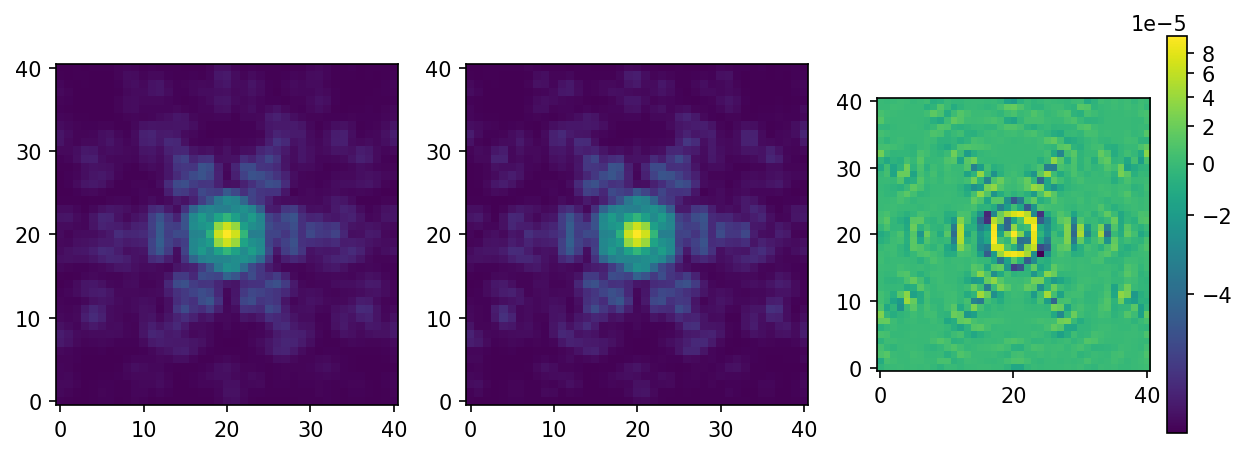

In [51]:
yy, xx = np.mgrid[-20:20.1:1,-20:20.1:1]
pl.figure(dpi=150, figsize=(10,3.5))
ax = pl.subplot(1,3,1)
imshow_norm(psf_410(xx, yy), ax=ax, stretch=LogStretch())
ax = pl.subplot(1,3,2)
imshow_norm(convolve(psf_bra(xx, yy), Gaussian2DKernel(0.3, x_size=41, y_size=41)), ax=ax, stretch=LogStretch())
ax = pl.subplot(1,3,3)
im, norm = imshow_norm(convolve(psf_bra(xx, yy), Gaussian2DKernel(0.3, x_size=41, y_size=41)) - psf_410(xx, yy), ax=ax, stretch=AsinhStretch())
pl.colorbar(mappable=im)

### Kernel

The BrA needs to be convolved with an 0.8469 * 0.1 pixel = 0.085 pixel Gaussian

or an 0.3469 * 0.5 = 0.017 pixel gaussian!?

or an 0.30 pixel gaussian?!

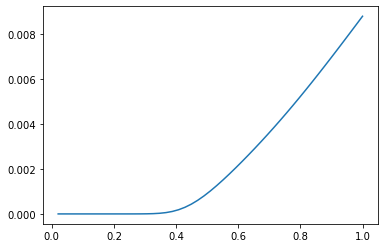

In [52]:
def residual2(x):
    return pb - convolve(p4, Gaussian2DKernel(x))
pl.plot(np.linspace(0,1), [(residual2(x)**2).sum() for x in np.linspace(0,1)])

# Further star removal via photometry

Starfinding on unsubtracted data so we can do some spatial cross-matching.

In [53]:
stars_bra = DAOStarFinder(threshold=60, fwhm=2.302, peakmax=1e4)(fh_405['SCI'].data)
stars_bra['skycoord'] = ww405.pixel_to_world(stars_bra['xcentroid'], stars_bra['ycentroid'])
len(stars_bra)

19451

In [54]:
stars_410 = DAOStarFinder(threshold=10, fwhm=2.302, peakmax=900)(fh_410['SCI'].data)
stars_410['skycoord'] = ww410.pixel_to_world(stars_410['xcentroid'], stars_410['ycentroid'])
len(stars_410)

75063

In [55]:
matches, sep, _ = stars_bra['skycoord'].match_to_catalog_sky(stars_410['skycoord'], nthneighbor=1)

for cn in stars_bra.colnames:
    stars_bra.rename_column(cn, f"{cn}_405")
for cn in stars_410.colnames:
    stars_410.rename_column(cn, f"{cn}_410")
                         
stars_bra.add_column(name="sep_410_405", col=sep)
stars_bra.add_column(name="id_410_405", col=matches)
mergetbl = table.hstack([stars_bra, stars_410[matches]], join_type='exact')

(array([1.6627e+04, 1.1620e+03, 6.9300e+02, 7.5300e+02, 1.5500e+02,
        4.0000e+01, 1.2000e+01, 4.0000e+00, 2.0000e+00, 3.0000e+00]),
 array([3.97053904e-04, 1.35673526e-01, 2.70949998e-01, 4.06226470e-01,
        5.41502942e-01, 6.76779414e-01, 8.12055886e-01, 9.47332357e-01,
        1.08260883e+00, 1.21788530e+00, 1.35316177e+00]),
 <BarContainer object of 10 artists>)

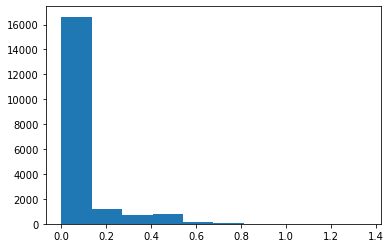

In [56]:
pl.hist(mergetbl['sep_410_405'].to(u.arcsec).value)

(-0.5, 0.5, -0.5, 0.5)

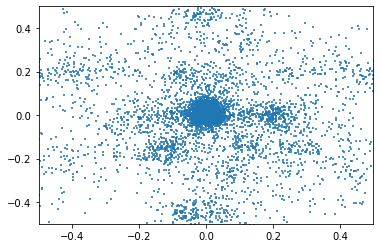

In [57]:
radiff = (mergetbl['skycoord_405'].ra - mergetbl['skycoord_410'].ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_405'].dec - mergetbl['skycoord_410'].dec).to(u.arcsec)
pl.scatter(radiff, decdiff, marker=',', s=1, alpha=0.8)
pl.axis([-0.5,0.5,-0.5,0.5])

Text(0, 0.5, 'Dec offset')

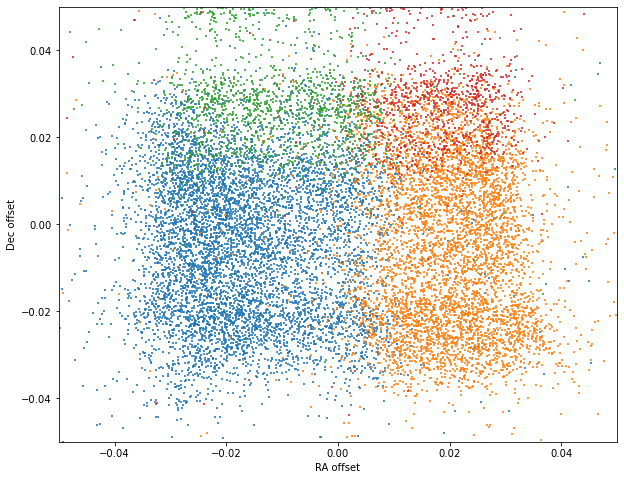

In [58]:
pl.figure(figsize=(10,8))
radiff = (mergetbl['skycoord_405'].ra - mergetbl['skycoord_410'].ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_405'].dec - mergetbl['skycoord_410'].dec).to(u.arcsec)
topleft = (mergetbl['xcentroid_405'] < 1424) & (mergetbl['ycentroid_405'] > 1024)
pl.scatter(radiff[topleft], decdiff[topleft], marker=',', s=1, alpha=0.8)
topright = (mergetbl['xcentroid_405'] > 1424) & (mergetbl['ycentroid_405'] > 1024)
pl.scatter(radiff[topright], decdiff[topright], marker=',', s=1, alpha=0.8)
bottomleft = (mergetbl['xcentroid_405'] < 1424) & (mergetbl['ycentroid_405'] < 1024)
pl.scatter(radiff[bottomleft], decdiff[bottomleft], marker=',', s=1, alpha=0.8)
bottomright = (mergetbl['xcentroid_405'] > 1424) & (mergetbl['ycentroid_405'] < 1024)
pl.scatter(radiff[bottomright], decdiff[bottomright], marker=',', s=1, alpha=0.8)
pl.axis([-0.05,0.05,-0.05,0.05])
pl.xlabel("RA offset")
pl.ylabel("Dec offset")

In [59]:
mergetbl['xcentroid_405'].max(), mergetbl['ycentroid_405'].max()

(2333.9108867728255, 5691.009560507395)

In [60]:
dist_from_center = ((mergetbl['xcentroid_405'] - 1450)**2 + (mergetbl['ycentroid_405'] - 1145)**2)**0.5

Text(0, 0.5, 'Offset from F410 (arcseconds)')

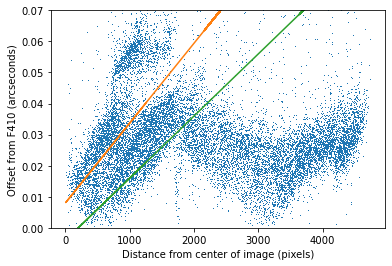

In [61]:
pl.plot(dist_from_center, mergetbl['sep_410_405'].to(u.arcsec).value, ',')
pl.plot(dist_from_center, dist_from_center/1750 * 0.045 + 0.008)
pl.plot(dist_from_center, dist_from_center/1750 * 0.035 - 0.004)
pl.ylim(0,0.07)
pl.xlabel("Distance from center of image (pixels)")
pl.ylabel("Offset from F410 (arcseconds)")

# The distortion is nearly linear!

This was a big discovery early on when I was still trying to get the images aligned.

In [62]:
ok = (mergetbl['sep_410_405'] < 0.05*u.arcsec) & (mergetbl['sep_410_405'] < (dist_from_center/1750*0.045 +0.08) *u.arcsec) & (mergetbl['sep_410_405'] > (dist_from_center/1750*0.035 - 0.08) *u.arcsec)

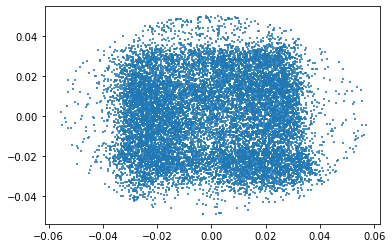

In [63]:
radiff = (mergetbl['skycoord_405'].ra - mergetbl['skycoord_410'].ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_405'].dec - mergetbl['skycoord_410'].dec).to(u.arcsec)
pl.scatter(radiff[ok], decdiff[ok], marker=',', s=1, alpha=0.8)

In [64]:
from astropy.wcs.utils import fit_wcs_from_points

In [65]:
ww_405_refit = fit_wcs_from_points([mergetbl['xcentroid_405'][ok], mergetbl['ycentroid_405'][ok]], mergetbl['skycoord_410'][ok], sip_degree=1)

In [66]:
ww_410_refit = fit_wcs_from_points([mergetbl['xcentroid_410'][ok], mergetbl['ycentroid_410'][ok]], mergetbl['skycoord_405'][ok], sip_degree=3)

In [67]:
skycoord_410_refit = ww_410_refit.pixel_to_world(mergetbl['xcentroid_410'], mergetbl['ycentroid_410'])

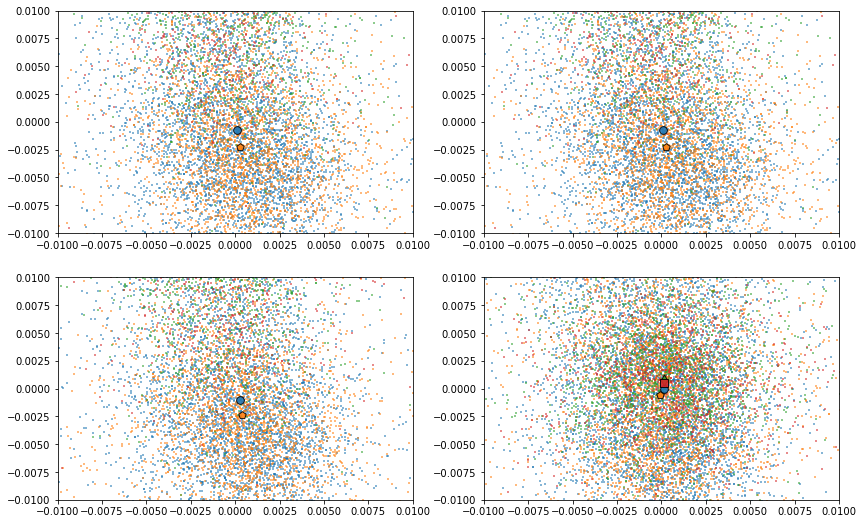

In [68]:
pl.figure(figsize=(14,9))
for sip_degree in (0,1,2,3):
    pl.subplot(2,2,sip_degree+1)
    
    ww_410_refit = fit_wcs_from_points([mergetbl['xcentroid_410'][ok], mergetbl['ycentroid_410'][ok]], mergetbl['skycoord_405'][ok], sip_degree=sip_degree)
    skycoord_410_refit = ww_410_refit.pixel_to_world(mergetbl['xcentroid_410'], mergetbl['ycentroid_410'])
    radiff = (mergetbl['skycoord_405'].ra - skycoord_410_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_405'].dec - skycoord_410_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    ww_410_refit = fit_wcs_from_points([mergetbl['xcentroid_410'][ok & (sep < 0.01*u.arcsec)], mergetbl['ycentroid_410'][ok & (sep < 0.01*u.arcsec)]], mergetbl['skycoord_405'][ok & (sep < 0.01*u.arcsec)], sip_degree=sip_degree)
    skycoord_410_refit = ww_410_refit.pixel_to_world(mergetbl['xcentroid_410'], mergetbl['ycentroid_410'])
    radiff = (mergetbl['skycoord_405'].ra - skycoord_410_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_405'].dec - skycoord_410_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    
    topleft = (mergetbl['xcentroid_405'] < 1424) & (mergetbl['ycentroid_405'] > 1024)
    sc = pl.scatter(radiff[topleft], decdiff[topleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topleft]), np.median(decdiff[topleft]), marker='o', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    topright = (mergetbl['xcentroid_405'] > 1424) & (mergetbl['ycentroid_405'] > 1024)
    sc = pl.scatter(radiff[topright], decdiff[topright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topright]), np.median(decdiff[topright]), marker='p', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomleft = (mergetbl['xcentroid_405'] < 1424) & (mergetbl['ycentroid_405'] < 1024)
    sc = pl.scatter(radiff[bottomleft], decdiff[bottomleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomleft]), np.median(decdiff[bottomleft]), marker='d', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomright = (mergetbl['xcentroid_405'] > 1424) & (mergetbl['ycentroid_405'] < 1024)
    sc = pl.scatter(radiff[bottomright], decdiff[bottomright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomright]), np.median(decdiff[bottomright]), marker='s', alpha=0.9, c=sc.get_facecolors(), zorder=25, edgecolors='k', s=60)
    pl.axis([-0.01,0.01,-0.01,0.01])

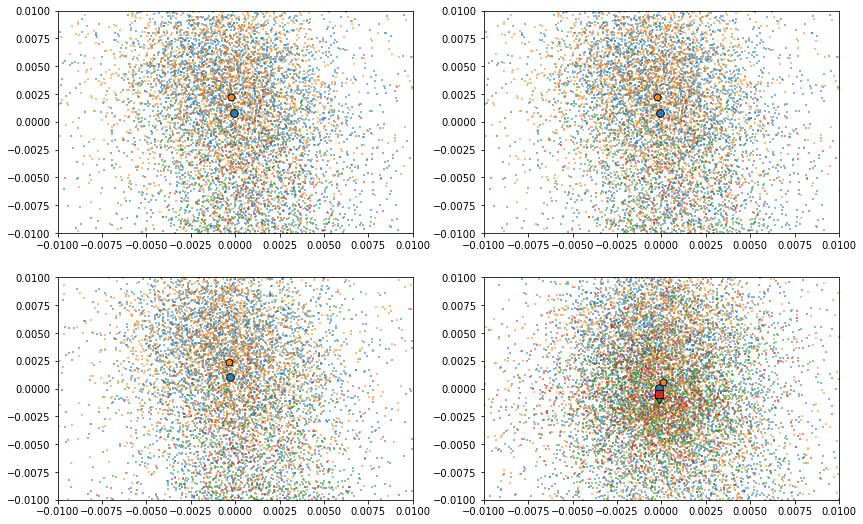

In [69]:
pl.figure(figsize=(14,9))
for sip_degree in (0,1,2,3):
    pl.subplot(2,2,sip_degree+1)
    
    ww_405_refit = fit_wcs_from_points([mergetbl['xcentroid_405'][ok], mergetbl['ycentroid_405'][ok]], mergetbl['skycoord_410'][ok], sip_degree=sip_degree)
    skycoord_405_refit = ww_405_refit.pixel_to_world(mergetbl['xcentroid_405'], mergetbl['ycentroid_405'])
    radiff = (mergetbl['skycoord_410'].ra - skycoord_405_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_410'].dec - skycoord_405_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    ww_405_refit = fit_wcs_from_points([mergetbl['xcentroid_405'][ok & (sep < 0.01*u.arcsec)], mergetbl['ycentroid_405'][ok & (sep < 0.01*u.arcsec)]], mergetbl['skycoord_410'][ok & (sep < 0.01*u.arcsec)], sip_degree=sip_degree)
    skycoord_405_refit = ww_405_refit.pixel_to_world(mergetbl['xcentroid_405'], mergetbl['ycentroid_405'])
    radiff = (mergetbl['skycoord_410'].ra - skycoord_405_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_410'].dec - skycoord_405_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    
    topleft = (mergetbl['xcentroid_405'] < 1424) & (mergetbl['ycentroid_405'] > 1024)
    sc = pl.scatter(radiff[topleft], decdiff[topleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topleft]), np.median(decdiff[topleft]), marker='o', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    topright = (mergetbl['xcentroid_405'] > 1424) & (mergetbl['ycentroid_405'] > 1024)
    sc = pl.scatter(radiff[topright], decdiff[topright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topright]), np.median(decdiff[topright]), marker='p', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomleft = (mergetbl['xcentroid_405'] < 1424) & (mergetbl['ycentroid_405'] < 1024)
    sc = pl.scatter(radiff[bottomleft], decdiff[bottomleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomleft]), np.median(decdiff[bottomleft]), marker='d', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomright = (mergetbl['xcentroid_405'] > 1424) & (mergetbl['ycentroid_405'] < 1024)
    sc = pl.scatter(radiff[bottomright], decdiff[bottomright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomright]), np.median(decdiff[bottomright]), marker='s', alpha=0.9, c=sc.get_facecolors(), zorder=25, edgecolors='k', s=60)
    pl.axis([-0.01,0.01,-0.01,0.01])

In [70]:
sip_degree = 3
ww_405_refit = fit_wcs_from_points([mergetbl['xcentroid_405'][ok], mergetbl['ycentroid_405'][ok]], mergetbl['skycoord_410'][ok], sip_degree=sip_degree)
skycoord_405_refit = ww_405_refit.pixel_to_world(mergetbl['xcentroid_405'], mergetbl['ycentroid_405'])
radiff = (mergetbl['skycoord_410'].ra - skycoord_405_refit.ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_410'].dec - skycoord_405_refit.dec).to(u.arcsec)
sep = (radiff**2 + decdiff**2)**0.5
ww_405_refit = fit_wcs_from_points([mergetbl['xcentroid_405'][ok & (sep < 0.01*u.arcsec)], mergetbl['ycentroid_405'][ok & (sep < 0.01*u.arcsec)]], mergetbl['skycoord_410'][ok & (sep < 0.01*u.arcsec)], sip_degree=sip_degree)
skycoord_405_refit = ww_405_refit.pixel_to_world(mergetbl['xcentroid_405'], mergetbl['ycentroid_405'])
radiff = (mergetbl['skycoord_410'].ra - skycoord_405_refit.ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_410'].dec - skycoord_405_refit.dec).to(u.arcsec)
sep = (radiff**2 + decdiff**2)**0.5


In [71]:
ww_405_refit.to_header(relax=True).totextfile(f'{basepath}/reduction/headers/f405n_merged-reproject_refitted_to_f410m.hdr', overwrite=True)

In [72]:
data_405_proj_410_refit, overlap_refit = reproject.reproject_exact((fh_405['SCI'].data, ww_405_refit), fh_410['SCI'].header)

In [73]:
fits.PrimaryHDU(data=data_405_proj_410_refit, header=fh_410['SCI'].header).writeto(f'{basepath}/images/F405_refitted405wcsto410_merged-reproject.fits', overwrite=True)

In [74]:
cont410_sub_bra = fh_410['SCI'].data - data_405_proj_410_refit*fractional_bandwidth_405
fits.PrimaryHDU(data=cont410_sub_bra, header=fh_410['SCI'].header).writeto(f'{basepath}/images/F410_minus_F405_refitted405wcsto410_merged-reproject.fits', overwrite=True)

In [75]:
bra_minus_cont = data_405_proj_410_refit - cont410_sub_bra #* fractional_bandwidth_405
fits.PrimaryHDU(data=bra_minus_cont, header=fh_410['SCI'].header).writeto(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_merged-reproject.fits', overwrite=True)

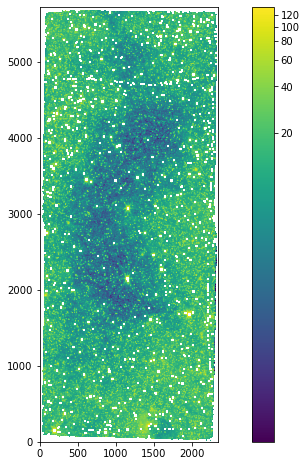

In [76]:
pl.figure(figsize=(12,8))
pl.imshow(cont410_sub_bra, norm=simple_norm(cont410_sub_bra, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar()

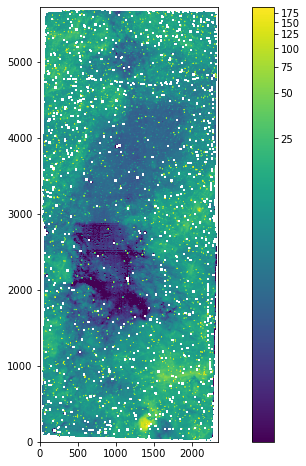

In [77]:
pl.figure(figsize=(12,8))
pl.imshow(bra_minus_cont, norm=simple_norm(bra_minus_cont, min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

In [78]:
latest_scalefactor = np.median(1/(mergetbl['flux_410'][ok]/mergetbl['flux_405'][ok]))
latest_scalefactor

0.17445857701140116

# Goal is to remove stars as completely as possible
we are not trying to measure H-alpha excess here but remove the stars entirely from the image to reveal the extended emission

if we were trying instead to measure stellar halpha excess, we'd want to stick to theory and/or match on something else (maybe extended emission)

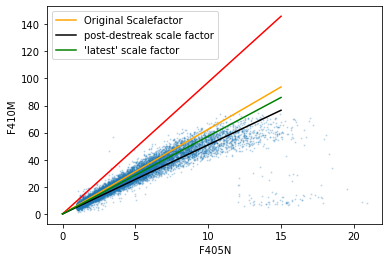

In [79]:
xr = np.linspace(0,15)
pl.scatter(mergetbl['flux_405'][ok], mergetbl['flux_410'][ok], s=1, alpha=0.2)
pl.plot(xr, xr/fractional_bandwidth_405, color='red', label='Fractional Bandwidth ratio')
scalefactor = 0.16
pl.plot(xr, xr/scalefactor, color='orange', label="Original Scalefactor")
post_destreak_scalefactor = 0.196
pl.plot(xr, xr/post_destreak_scalefactor, color='black', label="post-destreak scale factor")
pl.plot(xr, xr/latest_scalefactor, color='green', label="'latest' scale factor")
pl.legend(loc='best')
pl.xlabel("F405N")
pl.ylabel("F410M");

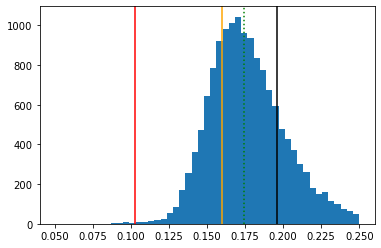

In [80]:
pl.hist(1/(mergetbl['flux_410'][ok]/mergetbl['flux_405'][ok]), bins=np.linspace(0.05,0.25))
pl.axvline(scalefactor, color='orange')
pl.axvline(post_destreak_scalefactor, color='black')
pl.axvline(fractional_bandwidth_405, color='red')
pl.axvline(latest_scalefactor, color='green', linestyle=':')

In [81]:
cont410_sub_bra = fh_410['SCI'].data - convolve_fft(data_405_proj_410_refit*latest_scalefactor, Gaussian2DKernel(0.3))
fits.PrimaryHDU(data=cont410_sub_bra, header=fh_410['SCI'].header).writeto(f'{basepath}/images/F410_minus_F405_refitted405wcsto410_merged-reproject.fits', overwrite=True)

In [82]:
bra_minus_cont = data_405_proj_410_refit - cont410_sub_bra#convolve_fft(cont410_sub_bra, Gaussian2DKernel(0.5)) #* fractional_bandwidth_405
fits.PrimaryHDU(data=bra_minus_cont, header=fh_410['SCI'].header).writeto(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_merged-reproject.fits', overwrite=True)

Re-examine the images afer the empirical subtraction

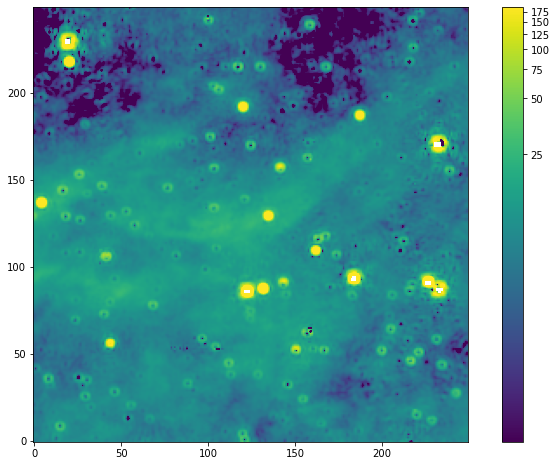

In [83]:
pl.figure(figsize=(12,8))
slc = slcgt()[1000:1250,1000:1250]
pl.imshow(bra_minus_cont[slc],
          norm=simple_norm(bra_minus_cont[slc], min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

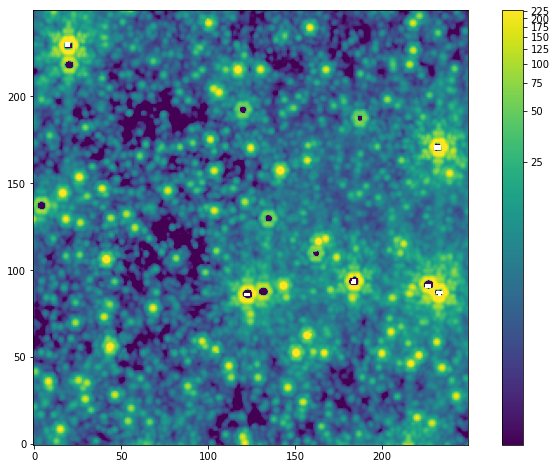

In [84]:
pl.figure(figsize=(12,8))
slc = slcgt()[1000:1250,1000:1250]
pl.imshow(cont410_sub_bra[slc],
          norm=simple_norm(cont410_sub_bra[slc], min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

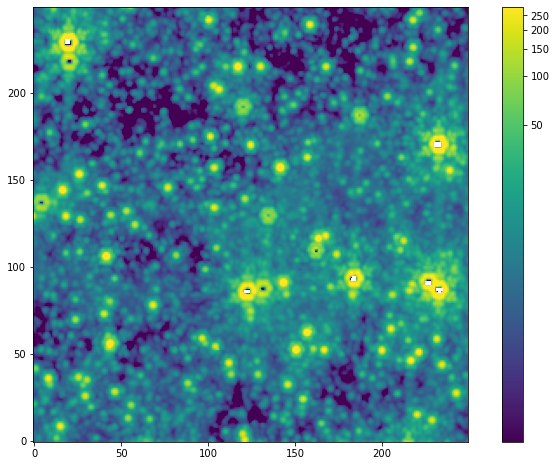

In [85]:
pl.figure(figsize=(12,8))
slc = slcgt()[1000:1250,1000:1250]
pl.imshow(fh_410['SCI'].data [slc],
          norm=simple_norm(fh_410['SCI'].data [slc], min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

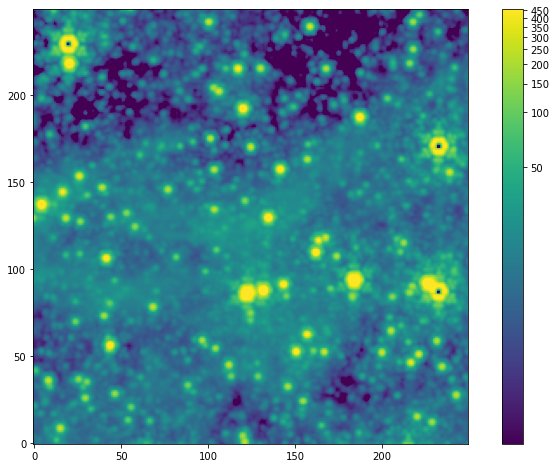

In [86]:
pl.figure(figsize=(12,8))
slc = slcgt()[1000:1250,1000:1250]
pl.imshow(data_405_proj_410_refit[slc],
          norm=simple_norm(data_405_proj_410_refit[slc], min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

# Try to find the right scaling factor for the stars

The above scaling factor assumed that the stellar flux in the BrA band matches that in the F410M band, which is only true if most stars do not have BrA absorption.

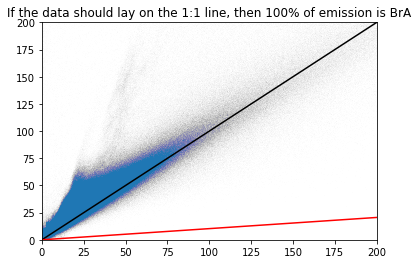

In [87]:
pl.scatter(fh_410['SCI'].data, data_405_proj_410_refit, s=1, alpha=0.005)
pl.plot([0,1000], [0,1000], color='k')
pl.plot([0,1000], [0,1000*fractional_bandwidth_405], color='r')
pl.axis([0,200,0,200]);
pl.title("If the data should lay on the 1:1 line, then 100% of emission is BrA");

Text(0.5, 1.0, 'The peak at 1.5x indicates that a large fraction of pixels are starry')

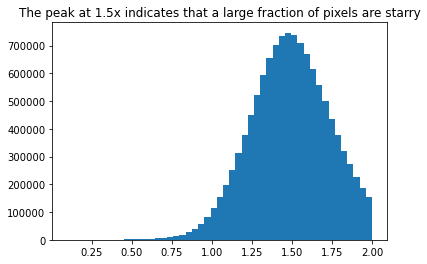

In [88]:
pl.hist((data_405_proj_410_refit / fh_410['SCI'].data)[(fh_410['SCI'].data < 200) & (data_405_proj_410_refit < 100)],
        bins=np.linspace(0.1,2));
pl.title("The peak at 1.5x indicates that a large fraction of pixels are starry")